### CSE 5320 Neural Networks Project 2
#### Report (with Code)
Josias Moukpe\
11/18/2022

#### Introduction
Object detection is an advanced form of image classification where a neural network predicts objects in an image and points them out in bounding boxes. Object detection thus refers to the detection and localization of objects in an image that belongs to a predefined set of classes. Tasks like detection, recognition, or localization find widespread applicability in real-world scenarios such as autonomous driving, robotics, product quality assurance, etc., making object detection (also referred to as object recognition) a very important subdomain of Computer Vision. [2] We call Real-Time object detection when the objects in images can be recognized in mere milliseconds allowing for in-time reactions based on the detection. Our project will aim to build a real-time object detector to find and track objects of defined classes in images or video feeds.

#### Problem
This objective combines object classificationn and localization (bounding box regression task). To process images and capture the features, we will leverage convolutional neural networks and capture local pixel structures. We will comment on how our model performs in real-time object detection. To train our model, we will use the MS COCO dataset [1]. This dataset contains more than 200,000 labeled color images of 1.5 million object instances and 80 object categories. Each image is 640 x 480 pixels and includes various forms of annotations such as key points, captions, segmentations, and bounding boxes (which interest us). The model will take an image or batch of images and outputs the classes and bounding boxes of all objects detected in that image.

#### Methodology
To prepare the data, we .

#### Benchmarking
To measure training performance, we 

#### Conclusion
Overall, 


References\
[1] https://cocodataset.org/#home \
[2] https://www.v7labs.com/blog/yolo-object-detection \
[3] https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/ \
[4] https://blog.paperspace.com/how-to-implement-a-yolo-v3-object-detector-from-scratch-in-pytorch-part-2/ \
[5] https://blog.paperspace.com/how-to-implement-a-yolo-v3-object-detector-from-scratch-in-pytorch-part-3/ \
[6] https://blog.paperspace.com/how-to-implement-a-yolo-v3-object-detector-from-scratch-in-pytorch-part-4/

Obtaining the COCO 2017 Dataset

In [2]:
# list the contents of the current 
# directory on my remote server
!ls
!ls "/notebooks/data/"

README.md  config  data  models
annotations  test2017  train2017  val2017


In [6]:
# navigate to the data directory
# and list the contents
# %cd "/notebooks/data"
# !ls

# # downloading coco (2017) dataset
# !wget http://images.cocodataset.org/zips/train2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip
# !wget http://images.cocodataset.org/zips/test2017.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# !wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
# !wget http://images.cocodataset.org/annotations/image_info_test2017.zip

# # unzip the files
# !unzip train2017.zip
# !unzip val2017.zip
# !unzip test2017.zip
# !unzip annotations_trainval2017.zip
# !unzip stuff_annotations_trainval2017.zip
# !unzip image_info_test2017.zip

# # remove the zip files
# !rm train2017.zip
# !rm val2017.zip
# !rm test2017.zip
# !rm annotations_trainval2017.zip
# !rm stuff_annotations_trainval2017.zip
# !rm image_info_test2017.zip

# navigate out of the data directory
# and list the contents
# %cd "/notebooks"
# !ls


In [11]:
# create a config directory
# %cd "/notebooks"
# %mkdir config
# %cd config
# !wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
# %cd ..

/notebooks
/notebooks/config
--2022-11-20 15:38:03--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0.01s   

2022-11-20 15:38:03 (675 KB/s) - ‘yolov3.cfg’ saved [8342/8342]

/notebooks


In [10]:
!pwd

/root


In [12]:
# create a models directory
# %cd "/notebooks"
# %mkdir models
# %cd models
# !wget -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights
# %cd ..

/notebooks
mkdir: cannot create directory ‘models’: File exists
/notebooks/models
--2022-11-20 15:54:10--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  5.13MB/s    in 44s     

2022-11-20 15:54:54 (5.41 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

/notebooks


In [4]:
# install gluoncv to help with the dataset
%pip install gluoncv
%pip install mxnet
%pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 30.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [92]:
# imports 
from __future__ import division

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import cv2
import matplotlib.pyplot as plt
from random import randint, choice
import pickle as pkl

from gluoncv import data, utils
# print the version of torch
print(torch.__version__)

1.12.0+cu116


In [6]:
# check if gpu is available
print(torch.cuda.get_device_name(0))

Quadro RTX 5000


### Loading the dataset
MS COCO 2017 is our dataset. Link to loaded dataset in our remote development compute node
https://console.paperspace.com/erud1t3/notebook/r92lxtvwhlbkhcy

In [7]:
!pwd

/notebooks


In [8]:
# loading the coco dataset
train_ds = data.COCODetection('./data/', splits=['instances_train2017'])
val_ds = data.COCODetection('./data/', splits=['instances_val2017'])

# print the length of the dataset
print('Length of training dataset:', len(train_ds))
print('Length of validation dataset:', len(val_ds))

/usr/local/lib/python3.9/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Collecting pycocotools

Downloading pycocotools-2.0.6.tar.gz (24 kB)

Installing build dependencies: started

Installing build dependencies: finished with status 'done'

Getting requirements to build wheel: started

Getting requirements to build wheel: finished with status 'done'

Preparing metadata (pyproject.toml): started

Preparing metadata (pyproject.toml): finished with status 'done'

Requirement already satisfied: matplotlib>=2.1.0 in /usr/local/lib/python3.9/dist-packages (from pycocotools) (3.5.2)

Requirement already satisfied: numpy in /usr/local/lib/python3.9/dist-packages (from pycocotools) (1.23.1)

Requirement already satisfied: fonttools>=4.22.0 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (4.34.4)

Requirement already satisfied: python-dateutil>=2.7 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (2.8.2)

Requirement already satisfied: pyparsing>=2.2.1 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (3.0.9)

Requirement already satisfied: packaging>=20.0 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (21.3)

Requirement already satisfied: kiwisolver>=1.0.1 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (1.4.3)

Requirement already satisfied: cycler>=0.10 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (0.11.0)

Requirement already satisfied: pillow>=6.2.0 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (9.2.0)

Requirement already satisfied: six>=1.5 in /usr/lib/python3/dist-packages (from python-dateutil>=2.7->matplotlib>=2.1.0->pycocotools) (1.14.0)

Building wheels for collected packages: pycocotools

Building wheel for pycocotools (pyproject.toml): started

Building wheel for pycocotools (pyproject.toml): finished with status 'done'

Created wheel for pycocotools: filename=pycocotools-2.0.6-cp39-cp39-linux_x86_64.whl size=400230 sha256=8ccdd4ad0bb04688c11adda314afb0e828c77f665a0958d0f71e3f8cd53f2691

Stored in directory: /root/.cache/pip/wheels/2f/58/25/e78f1f766e904a9071266661d20d0bc6644df86bcd160aba11

Successfully built pycocotools

Installing collected packages: pycocotools

Successfully installed pycocotools-2.0.6

WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv


loading annotations into memory...
Done (t=18.77s)
creating index...
index created!
loading annotations into memory...
Done (t=0.57s)
creating index...
index created!
Length of training dataset: 117266
Length of validation dataset: 4952


In [9]:
# plot a random image from coco dataset
def plot_image(image, label):
    '''
    Plots an image and its bounding boxes
    '''
    print('Image size (height, width, RGB):', image.shape)
    # print('Label:', label)
    print('shape of label:', label.shape)
    # plot the image
    bounding_boxes = label[:, :4]
    class_ids = label[:, 4:5]
    print('number of objects in the image:', bounding_boxes.shape[0])
    print('bounding boxes (# boxes, min x, min y, max x, max y): \n', bounding_boxes)
    print('class ids (# boxes, class id): \n', class_ids)
    ax = utils.viz.plot_bbox(
        image.asnumpy(), 
        bounding_boxes, 
        scores=None, 
        labels=class_ids, 
        class_names=train_ds.classes
    )
    plt.show()
  

Image size (height, width, RGB): (407, 500, 3)
shape of label: (9, 5)
number of objects in the image: 9
bounding boxes (# boxes, min x, min y, max x, max y): 
 [[290.04 257.15 448.31 341.47]
 [202.44 216.7  222.59 234.67]
 [206.03 257.92 349.72 341.5 ]
 [272.1  286.74 284.57 297.03]
 [ 71.94 297.72 115.12 332.07]
 [ 45.85 302.29  71.87 327.4 ]
 [ 15.9  299.4   41.31 321.46]
 [  0.   286.13  11.71 335.94]
 [427.5  258.43 499.   337.5 ]]
class ids (# boxes, class id): 
 [[7.]
 [0.]
 [7.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [7.]]


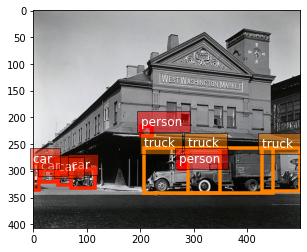

In [10]:
# pick a random image from validation dataset
image, label = val_ds[randint(0, len(val_ds))]
plot_image(image, label)


### Working the model
We will be building Yolo3 

In [11]:
def parse_config(cfg):
    """
    Takes a configuration file and returns a list of blocks. Each blocks describes a block in the neural
    """
    
    file = open(cfg, 'r')
    lines = file.read().split('\n') # store the lines in a list
    lines = [x for x in lines if len(x) > 0] # get read of the empty lines
    lines = [x for x in lines if x[0] != '#'] # get rid of comments
    lines = [x.rstrip().lstrip() for x in lines] # get rid of fringe whitespaces


    block = {}
    blocks = []

    for line in lines:
        if line[0] == "[":
            if len(block) != 0:
                blocks.append(block)
                block = {}
            block["type"] = line[1:-1].rstrip()
        else:
            key, value = line.split("=")
            block[key.rstrip()] = value.lstrip()
    blocks.append(block)

    return blocks



In [12]:
# empty layer 
class EmptyLayer(nn.Module):
    """
       Empty layer used for skipping layers in the neural network
    """
    def __init__(self):
        super(EmptyLayer, self).__init__()

In [13]:
# detection layer
class DetectionLayer(nn.Module):
    """
        Detection layer used for the detection of objects
    """
    def __init__(self, anchors):
        super(DetectionLayer, self).__init__()
        self.anchors = anchors

In [14]:
def create_modules(blocks):
    """
    Takes in a list of blocks and creates a nn.ModuleList of the blocks
    """

    net_info = blocks[0] # Captures the information about the input and pre-processing
    module_list = nn.ModuleList()
    prev_filters = 3
    output_filters = []

    for index, x in enumerate(blocks[1:]):
        module = nn.Sequential()

        # check the type of block
        # create a new module for the block
        # append to module_list

        if (x["type"] == "convolutional"):
            # Get the info about the layer
            activation = x["activation"]
            try:
                batch_normalize = int(x["batch_normalize"])
                bias = False
            except:
                batch_normalize = 0
                bias = True

            filters = int(x["filters"])
            padding = int(x["pad"])
            kernel_size = int(x["size"])
            stride = int(x["stride"])

            if padding:
                pad = (kernel_size - 1) // 2
            else:
                pad = 0

            # add the convolutional layer
            conv = nn.Conv2d(prev_filters, filters, kernel_size, stride, pad, bias=bias)
            module.add_module("conv_{0}".format(index), conv)

            # add the Batch Norm Layer
            if batch_normalize:
                bn = nn.BatchNorm2d(filters)
                module.add_module("batch_norm_{0}".format(index), bn)

            # check the activation.
            # it is either Linear or a Leaky ReLU for YOLO
            if activation == "leaky":
                activn = nn.LeakyReLU(0.1, inplace=True)
                module.add_module("leaky_{0}".format(index), activn)

        # If it's an upsampling layer
        # We use Bilinear2dUpsampling
        elif (x["type"] == "upsample"):
            stride = int(x["stride"])
            upsample = nn.Upsample(scale_factor=2, mode="bilinear")
            module.add_module("upsample_{}".format(index), upsample)

        # If it is a route layer
        elif (x["type"] == "route"):
            x["layers"] = x["layers"].split(',')
            # Start  of a route
            start = int(x["layers"][0])
            # end, if there exists one.
            try:
                end = int(x["layers"][1])
            except:
                end = 0
            # Positive annotation
            if start > 0: start = start - index
            if end > 0: end = end - index
            route = EmptyLayer()
            module.add_module("route_{0}".format(index), route)
            if end < 0:
                filters = output_filters[index + start] + output_filters[index + end]
            else:
                filters = output_filters[index + start]

        # shortcut corresponds to skip connection
        elif x["type"] == "shortcut":
            shortcut = EmptyLayer()
            module.add_module("shortcut_{}".format(index), shortcut)

        # Yolo is the detection layer
        elif x["type"] == "yolo":
            mask = x["mask"].split(",")
            mask = [int(x) for x in mask]

            anchors = x["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i+1]) for i in range(0, len(anchors),2)]
            anchors = [anchors[i] for i in mask]

            detection = DetectionLayer(anchors)
            module.add_module("Detection_{}".format(index), detection)

        module_list.append(module)
        prev_filters = filters
        output_filters.append(filters)

    return (net_info, module_list)

In [15]:
blocks = parse_config("config/yolov3.cfg")
print(create_modules(blocks))

({'type': 'net', 'batch': '64', 'subdivisions': '16', 'width': '608', 'height': '608', 'channels': '3', 'momentum': '0.9', 'decay': '0.0005', 'angle': '0', 'saturation': '1.5', 'exposure': '1.5', 'hue': '.1', 'learning_rate': '0.001', 'burn_in': '1000', 'max_batches': '500200', 'policy': 'steps', 'steps': '400000,450000', 'scales': '.1,.1'}, ModuleList(
  (0): Sequential(
    (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (1): Sequential(
    (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (2): Sequential(
    (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  

In [16]:
def predict_transform(prediction, inp_dim, anchors, num_classes, CUDA = True):
    """
        takes detection feature map and returns the bounding boxes 2D tensors
    """

    batch_size = prediction.size(0)
    stride =  inp_dim // prediction.size(2)
    grid_size = inp_dim // stride
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)

    prediction = prediction.view(batch_size, bbox_attrs * num_anchors, grid_size * grid_size)
    prediction = prediction.transpose(1,2).contiguous()
    prediction = prediction.view(batch_size, grid_size * grid_size * num_anchors, bbox_attrs)

    anchors = [(a[0]/stride, a[1]/stride) for a in anchors]

    # Sigmoid the  centre_X, centre_Y. and object confidencce
    prediction[:,:,0] = torch.sigmoid(prediction[:,:,0])
    prediction[:,:,1] = torch.sigmoid(prediction[:,:,1])
    prediction[:,:,4] = torch.sigmoid(prediction[:,:,4])

    # Add the center offsets
    grid = np.arange(grid_size)
    a,b = np.meshgrid(grid, grid)

    x_offset = torch.FloatTensor(a).view(-1,1)
    y_offset = torch.FloatTensor(b).view(-1,1)

    if CUDA:
        x_offset = x_offset.cuda()
        y_offset = y_offset.cuda()

    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1, num_anchors).view(-1, 2).unsqueeze(0)

    prediction[:,:,:2] += x_y_offset

    # log space transform height and the width
    anchors = torch.FloatTensor(anchors)

    if CUDA:
        anchors = anchors.cuda()

    anchors = anchors.repeat(grid_size * grid_size, 1).unsqueeze(0)
    prediction[:,:,2:4] = torch.exp(prediction[:,:,2:4]) * anchors

    prediction[:,:,5: 5 + num_classes] = torch.sigmoid((prediction[:,:, 5 : 5 + num_classes]))

    prediction[:,:,:4] *= stride

    return prediction

In [49]:
# build the network from the blocks and the module list
class Darknet(nn.Module):
    """
    YOLOv3 object detection model based on Darknet architecture
    """

    def __init__(self, cfg):
        super(Darknet, self).__init__()
        self.blocks = parse_config(cfg)
        self.net_info, self.module_list = create_modules(self.blocks)

    def forward(self, x, CUDA):
        modules = self.blocks[1:]
        outputs = {}   #We cache the outputs for the route layer

        write = 0
        for i, module in enumerate(modules):
            module_type = (module["type"])

            if module_type == "convolutional" or module_type == "upsample":
                x = self.module_list[i](x)

            elif module_type == "route":
                layers = module["layers"]
                layers = [int(a) for a in layers]

                if (layers[0]) > 0: layers[0] = layers[0] - i
                if len(layers) == 1:
                    x = outputs[i + (layers[0])]

                else:
                    if (layers[1]) > 0: layers[1] = layers[1] - i

                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]

                    x = torch.cat((map1, map2), 1)

            elif  module_type == "shortcut":
                from_ = int(module["from"])
                x = outputs[i-1] + outputs[i+from_]

            elif module_type == 'yolo':
                anchors = self.module_list[i][0].anchors
                #Get the input dimensions
                inp_dim = int (self.net_info["height"])

                #Get the number of classes
                num_classes = int (module["classes"])

                #Transform
                x = x.data
                x = predict_transform(x, inp_dim, anchors, num_classes, CUDA)
                if not write:              #if no collector has been intialised.
                    detections = x
                    write = 1

                else:
                    detections = torch.cat((detections, x), 1)

            outputs[i] = x

        return detections

    # leading the weights from the darknet model
    def load_weights(self, weightfile):
        """
            Loads weights from a weights file
        """

        # Open the weights file
        fp = open(weightfile, "rb")

        # The first 5 values are header information
        # 1. Major version number
        # 2. Minor Version Number
        # 3. Subversion number
        # 4,5. Images seen by the network (during training)

        header = np.fromfile(fp, dtype = np.int32, count = 5)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]

        weights = np.fromfile(fp, dtype = np.float32)

        ptr = 0
        for i in range(len(self.module_list)):
            module_type = self.blocks[i + 1]["type"]

            # If module_type is convolutional load weights
            # Otherwise ignore.

            if module_type == "convolutional":
                model = self.module_list[i]
                try:
                    batch_normalize = int(self.blocks[i+1]["batch_normalize"])
                except:
                    batch_normalize = 0

                conv = model[0]

                if (batch_normalize):
                    bn = model[1]

                    #Get the number of weights of Batch Norm Layer
                    num_bn_biases = bn.bias.numel()

                    #Load the weights
                    bn_biases = torch.from_numpy(weights[ptr:ptr + num_bn_biases])
                    ptr += num_bn_biases

                    bn_weights = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases

                    bn_running_mean = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases

                    bn_running_var = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases

                    #Cast the loaded weights into dims of model weights.
                    bn_biases = bn_biases.view_as(bn.bias.data)
                    bn_weights = bn_weights.view_as(bn.weight.data)
                    bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                    bn_running_var = bn_running_var.view_as(bn.running_var)

                    #Copy the data to model
                    bn.bias.data.copy_(bn_biases)
                    bn.weight.data.copy_(bn_weights)
                    bn.running_mean.data.copy_(bn_running_mean)
                    bn.running_var.data.copy_(bn_running_var)

                else:
                    #Number of biases
                    num_biases = conv.bias.numel()

                    #Load the weights
                    conv_biases = torch.from_numpy(weights[ptr: ptr + num_biases])
                    ptr = ptr + num_biases

                    #reshape the loaded weights according to the dims of the model weights
                    conv_biases = conv_biases.view_as(conv.bias.data)

                    #Finally copy the data
                    conv.bias.data.copy_(conv_biases)

                #Let us load the weights for the Convolutional layers
                num_weights = conv.weight.numel()

                #Do the same as above for weights
                conv_weights = torch.from_numpy(weights[ptr:ptr+num_weights])
                ptr = ptr + num_weights

                conv_weights = conv_weights.view_as(conv.weight.data)
                conv.weight.data.copy_(conv_weights)

    # def save_weights(self, savedfile, cutoff=0):
    #     """
    #         Saves the weights from the model into a file
    #     """
    #     fp = open(savedfile, 'wb')
    #     self.header[3] = self.seen
    #     self.header.numpy().tofile(fp)
    #     # The model is saved in the order (Conv, BN, Leaky ReLU)
    #     # We are storing the weights in the order (BN, Conv, Leaky ReLU)
    #     # We will be loading the weights in the same order (BN, Conv, Leaky ReLU)
    #     # The only problem is that we are storing the weights as 1D arrays
    #     # We will have to reshape the weights before storing them
    #     for i in range(0, cutoff if cutoff else len(self.module_list)):
    #         module_type = self.blocks[i + 1]['type']

            
    #         fp

In [19]:
def convert_to_yolo(label, direction='to_yolo'):
    '''
    Converts the bounding boxes into the yolo format
    and vice versa
    '''
    if direction == 'to_yolo':
        # convert the bounding boxes to yolo format
        # (x, y, w, h) -> (x, y, w, h)
        # (x, y) = (x + w/2, y + h/2)
        # (w, h) = (w, h)
        yolo_label = np.zeros(label.shape)

        yolo_label[:, 0] = label[:, 0] + label[:, 2]/2
        yolo_label[:, 1] = label[:, 1] + label[:, 3]/2
        yolo_label[:, 2] = label[:, 2]
        yolo_label[:, 3] = label[:, 3]
        yolo_label[:, 4] = label[:, 4]
        return yolo_label
    elif direction == 'to_normal':
        # convert the bounding boxes to normal format
        # (x, y, w, h) -> (x, y, w, h)
        # (x, y) = (x - w/2, y - h/2)
        # (w, h) = (w, h)
        normal_label = np.zeros(label.shape)

        normal_label[:, 0] = label[:, 0] - label[:, 2]/2
        normal_label[:, 1] = label[:, 1] - label[:, 3]/2
        normal_label[:, 2] = label[:, 2]
        normal_label[:, 3] = label[:, 3]
        normal_label[:, 4] = label[:, 4]
        return normal_label
    else:
        print('Invalid direction')
        return None

In [55]:
!pwd

/notebooks


In [74]:
# preprocess the data into the format required by the model
def get_test_image():
    '''
    Preprocess the image to be fed into the neural network
    '''
    path = './data/test2017/000000000001.jpg'
    img = cv2.imread(path)
    img = cv2.resize(img, (608,608))          #Resize to the input dimension
    img_ =  img[:,:,::-1].transpose((2,0,1))  # BGR -> RGB | H X W C -> C X H X W 
    img_ = img_[np.newaxis,:,:,:]/255.0       #Add a channel at 0 (for batch) | Normalise
    img_ = torch.from_numpy(img_).float()     #Convert to float
    img_ = Variable(img_)                     # Convert to Variable
    return img_

In [90]:
def img_preprocess(img, inp_dim=(608, 608)):
    '''
    Preprocess the image to be fed into the neural network
    '''

    # convert mxnet image to cv2 image
    img = img.asnumpy() 

    # img_w, img_h = img.shape[1], img.shape[0]
    # w, h = inp_dim
    # new_w = int(img_w * min(w/img_w, h/img_h))
    # new_h = int(img_h * min(w/img_w, h/img_h))
    # resized_image = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_CUBIC)
    
    # canvas = np.full((inp_dim[1], inp_dim[0], 3), 128)

    # canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image

    # preprocess the image
    
 
    img = cv2.resize(img, inp_dim) # resize the image
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert the image to RGB
    img_ =  img[:,:,::-1].transpose((2,0,1))  # BGR -> RGB | H X W C -> C X H X W 
    img_ = img_[np.newaxis,:,:,:]/255.0       #Add a channel at 0 (for batch) | Normalise
    img_ = torch.from_numpy(img_).float()     #Convert to float
    img_ = Variable(img_)                     # Convert to Variable

    return img_ #, canvas



In [79]:
# test untrain model on a random image from validation set
model = Darknet("config/yolov3.cfg")
model.cuda()
# read image from validation set
image, label = val_ds[randint(0, len(val_ds))]
print(image.shape)
# preprocess image
# yolo_img = get_test_image()
yolo_img = img_preprocess(image)
# forward pass
pred = model(yolo_img.cuda(), torch.cuda.is_available())
print(pred.shape)
# print the prediction
print(pred)

(640, 640, 3)
torch.Size([1, 22743, 85])
tensor([[[1.6424e+01, 1.2835e+01, 1.1703e+02,  ..., 4.4518e-01,
          4.9137e-01, 5.1244e-01],
         [1.5924e+01, 1.6846e+01, 1.1791e+02,  ..., 5.1997e-01,
          4.5027e-01, 2.9727e-01],
         [1.3770e+01, 1.7219e+01, 3.1521e+02,  ..., 5.9323e-01,
          5.5562e-01, 4.3909e-01],
         ...,
         [6.0395e+02, 6.0480e+02, 7.9989e+00,  ..., 5.1511e-01,
          4.1231e-01, 5.5579e-01],
         [6.0426e+02, 6.0426e+02, 1.9318e+01,  ..., 4.9539e-01,
          4.4893e-01, 4.9679e-01],
         [6.0447e+02, 6.0341e+02, 3.3204e+01,  ..., 5.1976e-01,
          4.8154e-01, 4.5693e-01]]], device='cuda:0')


In [80]:
model = Darknet("config/yolov3.cfg")
model.load_weights("models/yolov3.weights")

In [82]:
def unify(tensor):
    '''
        Returns the unique elements of a tensor
    '''

    tensor_np = tensor.cpu().numpy()
    unique_np = np.unique(tensor_np)
    unique_tensor = torch.from_numpy(unique_np)

    tensor_res = tensor.new(unique_tensor.shape)
    tensor_res.copy_(unique_tensor)
    
    return tensor_res


In [81]:
def bbox_iou(box1, box2):
    """ 
        Returns the IoU of two bounding boxes 
    """

    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)

    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)

    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area)

    return iou

In [84]:
def write_results(prediction, confidence, num_classes, nms_conf = .4):
    """
        Returns detections with shape:
            (x1, y1, x2, y2, object_conf, class_score, class_pred)
    """

    conf_mask = (prediction[:,:,4] > confidence).float().unsqueeze(2)
    prediction = prediction*conf_mask

    box = prediction.new(prediction.shape)
    box[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2)
    box[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box[:,:,:4]

    batch_size = prediction.size(0)

    write = False

    for ind in range(batch_size):
        image_pred = prediction[ind]          #image Tensor
        #confidence threshholding
        #NMS
        max_conf, max_conf_score = torch.max(image_pred[:,5:5+num_classes], 1)
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_score = max_conf_score.float().unsqueeze(1)
        seq = (image_pred[:,:5], max_conf, max_conf_score)
        image_pred = torch.cat(seq, 1)

        non_zero_ind =  (torch.nonzero(image_pred[:,4]))
        try:
            image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
        except:
            continue

        # if image_pred_.shape[0] == 0:
        #     continue

        #Get the classes detected in the image
        img_classes = unify(image_pred_[:,-1]) 

        # perform NMS classwise
        for cls in img_classes:
            #get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).float().unsqueeze(1)
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            image_pred_class = image_pred_[class_mask_ind].view(-1,7)

            #sort the detections such that the entry with the maximum objectness
            #confidence is at the top
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]
            image_pred_class = image_pred_class[conf_sort_index]
            idx = image_pred_class.size(0)  

            for i in range(idx):
                #Get the IOUs of all boxes that come after the one we are looking at 
                #in the loop
                try:
                    ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                except ValueError:
                    break

                except IndexError:
                    break

                #Zero out all the detections that have IoU > treshhold
                iou_mask = (ious < nms_conf).float().unsqueeze(1)
                image_pred_class[i+1:] *= iou_mask       

                #Remove the non-zero entries
                non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                image_pred_class = image_pred_class[non_zero_ind].view(-1,7)

            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)      
            #Repeat the batch_id for as many detections of the class cls in the image
            seq = batch_ind, image_pred_class

            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))

    try:
        return output
    except:
        return 0


In [87]:
# get all class names
%cd "./data/"
!wget https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/data/coco.names
%cd ..


/notebooks/data
--2022-11-20 20:44:35--  https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘coco.names.2’

coco.names.2        100%[===================>]     625  --.-KB/s    in 0s      

2022-11-20 20:44:35 (36.2 MB/s) - ‘coco.names.2’ saved [625/625]

/notebooks


In [88]:
def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names

In [89]:
num_classes = 80
classes = load_classes("./data/coco.names")

In [91]:
model = Darknet("config/yolov3.cfg")
model.load_weights("models/yolov3.weights")

if torch.cuda.is_available():
    model.cuda()
# put model in eval mode
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch

In [ ]:
write = False
output = None
# detection phase
image, label = val_ds[randint(0, len(val_ds))]
# plot image
plot_image(image, label)

# detect objects
yolo_img = img_preprocess(image)
# forward pass
pred = model(yolo_img.cuda(), torch.cuda.is_available())
# print the prediction
# print(pred)
write_results(pred, 0.5, num_classes)

if not write :
    output = pred
    write = True
else:
    output = torch.cat((output, pred))

print(output)

# draw bounding boxes
try:
    print(output)
except NameError:
    print("No object detected")


In [93]:
def writebbox(img, output, classes):
    """
    write bounding boxes on image 
    img: image to draw bounding boxes on
    output: output of write_results
    classes: list of class names
    """

    colors = pkl.load(open("pallete", "rb"))

    # get bounding box coordinates
    c1 = tuple(output[0:2].int())
    c2 = tuple(output[2:4].int())
    cls = int(output[-1])
    label = "{0}".format(classes[cls])
    color = choice(colors)
    cv2.rectangle(img, c1, c2, color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2, color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    
    return img